# Load

In [1]:
library(poem)

Registered S3 method overwritten by 'e1071':
  method       from  
  print.fclust fclust



In [2]:
library(ggplot2)
library(tidyr)
library(cowplot)
library(dplyr)
library(grid)
library(ggtext)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
fuzzy_true = TRUE
fuzzy_pred = FALSE
useMedianDist = TRUE

# Data
Simulate Visium-like hexagonal grid data

In [4]:
# Define the grid dimensions
n_rows <- 16
n_cols <- 15  

simulate_array <- function(n_rows=10, n_cols=10){
  # Create coordinates for the hexagonal grid
  array <- data.frame(row = integer(), col = integer())
  
  for (r in 0:(n_rows - 1)) {
    if (r %% 2 == 0) {
      # Even row: column indices are even (0, 2, 4, ...)
      cols <- seq(0, n_cols*2 - 1, by = 2)
    } else {
      # Odd row: column indices are odd (1, 3, 5, ...)
      cols <- seq(1, n_cols*2 - 1, by = 2)
    }
    # Add to coordinates data frame
    array <- rbind(array, data.frame(row = r, col = cols))
  }
  return(array)
}

simulate_hexagonal_grid <- function(n_rows=10, n_cols=10){
  hex_radius <- 1
  hex_height <- 1.5 * hex_radius
  
  # Initialize vectors to store the x and y coordinates
  x_coords <- numeric(n_rows * n_cols)
  y_coords <- numeric(n_rows * n_cols)
  
  index <- 1
  
  for (row in 1:n_rows) {
    for (col in 1:n_cols) {
      # Calculate x and y for the center of the hexagon
      x <- col * sqrt(3) * hex_radius
      y <- row * hex_height
      
      # Shift alternate rows
      if (row %% 2 == 0) {
        x <- x + sqrt(3)/2
      }
      
      # Store the coordinates
      x_coords[index] <- x
      y_coords[index] <- y
      index <- index + 1
    }
  }
  
  # Return the coordinates as a data frame
  coords <- data.frame(x = x_coords, y = y_coords)
  coords <- cbind(coords, simulate_array(n_rows, n_cols))
  return(coords)
}


data <- simulate_hexagonal_grid(n_rows, n_cols)
data$label <- NA
for (i in 1:dim(data)[1]) {
  if(data[i, "col"] > data[i, "row"] + 6){
    data[i, "label"] <- 1
  }else{
  data[i, "label"] <- 2
  }
}
data$label <- factor(data$label)

Simulate some errors

In [5]:
s <- 3
st <- 1

data$p2 <- data$label
data[data$row == 4 & (data$col %in% c(12,14,16,18,20)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 5 & (data$col %in% c(13,15,17,19)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 6 & (data$col %in% c(14,16,18,20)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 7 & (data$col %in% c(15,17,19)), "p2"] <- factor(2, levels=c(1,2))

data$p1 <- data$label
for (i in unique(data$row)) {
  data[data$row==i & data$col==i+8, "p1"] <- factor(2, levels=c(1,2))
} 

p0 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=label)) + 
  labs(x="",y="", title="GT1") 


p1 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p1)) + 
  labs(x="",y="", title="P1") 


p2 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p2)) + 
  labs(x="",y="", title="P2") 

In [6]:
# data$p3 <- data$label
# data[data$row == 3 & (data$col %in% c(21,23)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 4 & (data$col %in% c(12,14)), "p3"] <- factor(2, levels=c(1,2))
# data[data$row == 5 & (data$col %in% c(13,15)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 6 & (data$col %in% c(18)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 5 & (data$col %in% c(21,23)), "p3"] <- factor(2, levels=c(1,2))
# data[data$row == 6 & (data$col %in% c(22)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 9 & (data$col %in% c(25)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 12 & (data$col %in% c(22,26)), "p3"] <- factor(2, levels=c(1,2))

# data[data$row == 10 & (data$col %in% c(18,20)), "p3"] <- factor(2, levels=c(1,2))
# data[data$row == 11 & (data$col %in% c(19)), "p3"] <- factor(2, levels=c(1,2))

# p3 <- ggplot(data, aes(x, y, 
#                color=label)) + 
#   geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
#   geom_point(shape = 1, size = s, stroke = st, aes(color=p3)) + 
#   labs(x="",y="", title="P3") 

In [7]:
modlabs <- function(m, d, newlab=2){
  for(i in seq_along(m)){
    w <- which(d$row==(m[[i]][[1]]-1) & d$col %in% m[[i]][[2]])
    d$label[w] <- as.character(newlab)
  }
  d
}
m3 <- list(list(2,c(15,17)),
          list(3,c(14,16)),
          list(5,c(12,14)),
          list(6,c(13,15)),
          list(8,c(19,21)),
          list(9,c(20)),
          list(11, c(18,20)),
          list(12, c(19,21)),
          list(14, c(25))
          )
m4 <- list(list(2,4+c(15,17)),
          list(3,4+c(14,16)),
          list(5,c(12,14)),
          list(6,c(13,15)),
          list(8,4+c(19,21)),
          list(9,4+c(20)),
          list(11, c(18,20)),
          list(12, c(19,21)),
          list(14, 4+c(25))
          )

data$p3 <- modlabs(m3, data)$label
data$p4 <- modlabs(m4, data)$label

In [8]:
p3 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p3)) + 
  labs(x="",y="", title="P3") 

p4 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p4)) + 
  labs(x="",y="", title="P4") 

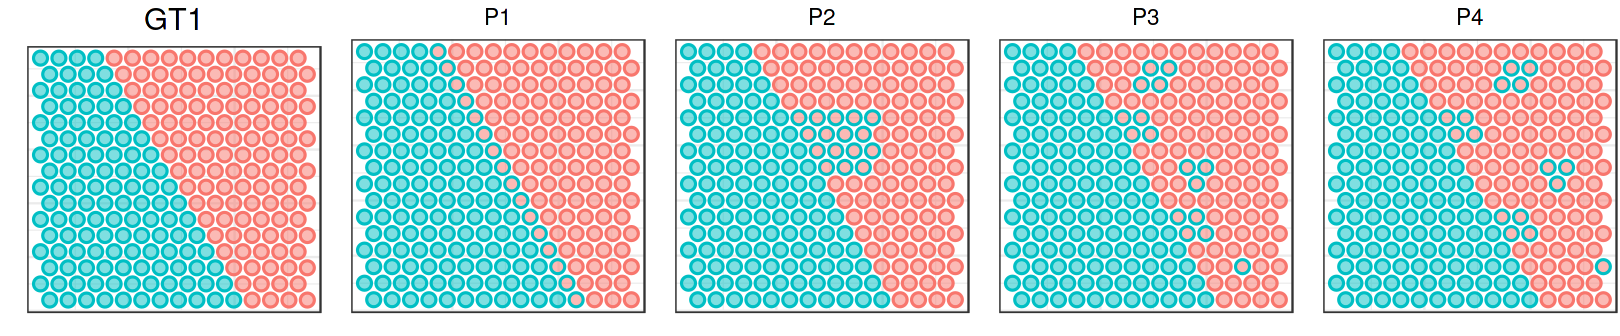

In [9]:
options(repr.plot.width=13.5, repr.plot.height=2.8)
# grDevices::cairo_pdf("Fig1.pdf", width=10, height=3)
p0 <- p0 + theme(legend.position = "none", plot.title = element_text(size=18, hjust = 0.5), plot.margin = margin(5, 2, -2, 0), 
axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
p1 <- p1 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
p2 <- p2 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()) 
p3 <- p3 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
p4 <- p4 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
ps1 <- plot_grid(p0, p1, p2, p3, p4, ncol = 5)
plot(ps1)
# dev.off()


# Dataset-level metrics

In [10]:
k <- 6
pred <- c("p1","p2","p3","p4")
pred_name <- c("P1","P2","P3", "P4")
label <- data$label
location <- data[, c('x','y')]
internal <-lapply(setNames(c("label","p1","p2","p3","p4"), c("C","P1","P2","P3","P4")), function(x){getSpatialInternalMetrics(labels=data[[x]], location=location, k=k, level="dataset", metrics=c("PAS", "ELSA", "CHAOS","MPC", "PC", "PE"))})
internal <- bind_rows(internal,.id = "prediction")
externalSpatial <- lapply(setNames(pred, pred_name), function(x){getSpatialExternalMetrics(true=label, pred=data[[x]], location=location, fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, level="dataset", 
                                                                                                 metrics=c("nsRI","nsARI","nsWH","nsAWH", "nsWC","nsAWC","nsAccuracy", "SpatialARI", "SpatialRI"),
                                                                                                 useMedianDist=useMedianDist)})
externalSpatial <- bind_rows(externalSpatial, .id = "prediction")                                                                                                

externalNormal <- lapply(setNames(pred, pred_name), function(x){getPartitionMetrics(label, data[[x]], metrics=c("RI","WC","WH","ARI","AWC","AWH","Accuracy"), level="dataset")})
externalNormal <- bind_rows(externalNormal, .id = "prediction")

the specified variable is considered as categorical...
the specified variable is considered as categorical...
the specified variable is considered as categorical...
the specified variable is considered as categorical...
the specified variable is considered as categorical...


Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000546

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000397

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000873

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000652



In [11]:
internal <- pivot_longer(internal, cols=-c("prediction"), names_to = "metric", values_to = "value")
dfc <- internal %>% filter(prediction == "C")
internal <- internal %>% filter(prediction != "C")
internal <- merge(internal, dfc, by.x = c("metric"), by.y = c("metric")) %>% select(-prediction.y) %>% rename(C = value.y) %>% rename(prediction = prediction.x) %>% rename(value = value.x) 
head(internal)


,metric,prediction,value,C
,<chr>,<chr>,<dbl>,<dbl>
1,CHAOS,P1,0.23058662,0.23058662
2,CHAOS,P2,0.23058662,0.23058662
3,CHAOS,P3,0.23225273,0.23058662
4,CHAOS,P4,0.23393246,0.23058662
5,ELSA,P1,0.06166950,0.05940498
6,ELSA,P2,0.07990288,0.05940498


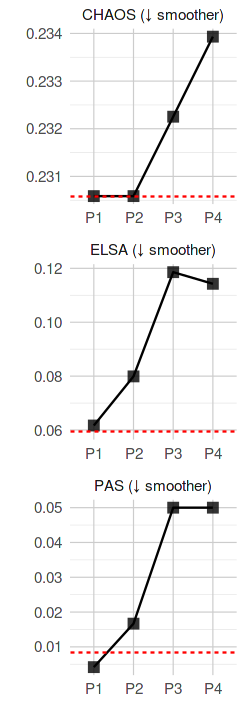

In [12]:
options(repr.plot.width=2, repr.plot.height=6)
pi1 <- internal %>% 
filter(metric %in% c("PAS", "ELSA", "CHAOS")) %>%
# filter(prediction %in% c('P1','P2')) %>%
ggplot(aes(x=prediction, y=value)) +
geom_point(size=3, alpha=0.8, shape=15) +
geom_line(aes(group=metric)) +
facet_wrap(~metric, scales = "free", ncol=1,
            labeller = as_labeller(c("PAS" = "PAS (↓ smoother)",
                                     "ELSA" = "ELSA (↓ smoother)",
                                     "CHAOS" = "CHAOS (↓ smoother)"))) +
geom_hline(aes(yintercept = C), linetype = "dashed", color = "red") +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm"),
    plot.margin = margin(0, 2, 0, 1)) +  
theme(legend.position = "bottom", legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="", x="") 
pi1

In [13]:
external <- merge(externalSpatial, externalNormal, by="prediction")
external <- pivot_longer(external, cols=-c("prediction"), names_to = "metric", values_to = "value")
external$metric_class <- sub("ns", "", external$metric)
external$metric_class <- sub("Spatial", "", external$metric_class)
external$metric_type <- ifelse(grepl("ns",external$metric) , "Neighborhood Smoothed", "NonSpatial")
external$metric_type <- ifelse(grepl("Spatial",external$metric) , "Distance Weighted", external$metric_type)
external <- data.frame(external)
external[external$metric=="nsAccuracy", "metric_class"] <- "Set Matching\nAccuracy"
external[external$metric=="Accuracy", "metric_class"] <- "Set Matching\nAccuracy"

In [14]:
unique(external$metric_class)

[1] "RI"                     "ARI"                    "WH"                    
[4] "AWH"                    "WC"                     "AWC"                   
[7] "Set Matching\nAccuracy"

In [15]:
external$metric_class <- factor(external$metric_class, levels=c('RI','ARI','WH','AWH','WC','AWC','Set Matching\nAccuracy'))


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


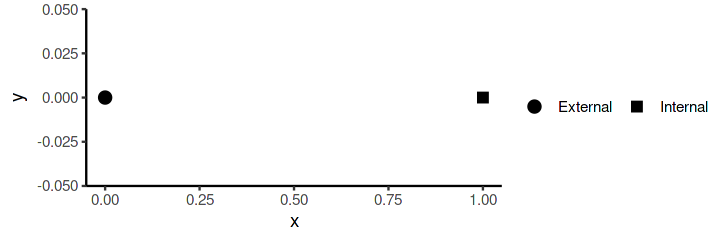

In [16]:
options(repr.plot.width=6, repr.plot.height=2)
plot_with_legend <- ggplot(data.frame(type=c("External","Internal"), x=c(0,1)), aes(x = x, y = 0, shape = type)) +
  geom_point(size=3) +
  scale_shape_manual(values = c(19, 15)) + labs(shape="") +
  theme_classic() +
  guides(shape = guide_legend(nrow = 1)) +
  theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt")) 
  
legend <- get_legend(plot_with_legend)
plot_with_legend

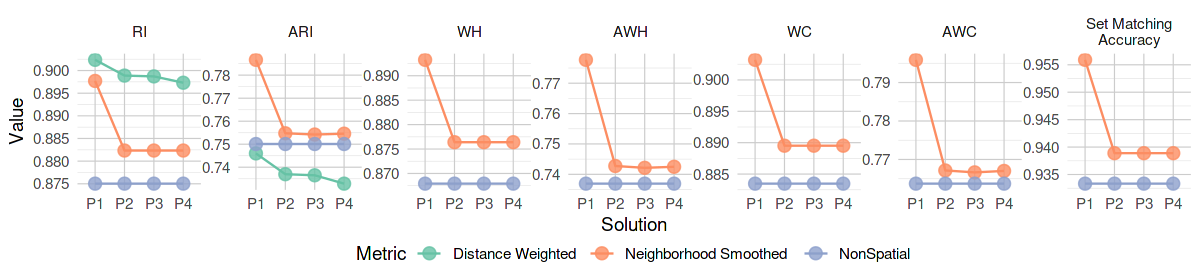

In [17]:
options(repr.plot.width=10, repr.plot.height=2.3)
pxx1 <- external %>% 
ggplot(aes(x=prediction, y=value, color=metric_type)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=metric)) +
facet_wrap(~metric_class, scales = "free", nrow=1) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.5, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Metric")  +
scale_color_brewer(palette = "Set2")
# ylim(0.7, 0.96)
pxx1

# Class metrics

In [18]:
externalSpatialClass <- do.call(rbind, lapply(setNames(pred, pred_name), function(x){as.data.frame(getSpatialExternalMetrics(true=label, pred=data[[x]], location=location, level="class", fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, metrics=c("nsWH","nsAWH", 
                                                     "nsWC","nsAWC")))}))
externalSpatialClass$prediction <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[1]})
dfl <- externalSpatialClass %>% pivot_longer(cols = c("nsWH","nsAWH", "nsWC","nsAWC"), names_to = "metric", values_to = "value")
dfl$metric <- factor(dfl$metric, levels=c("nsWH","nsAWH", "nsWC","nsAWC"))

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00102

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000974

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000673

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00105



In [19]:
df1 <- dfl %>% filter(metric %in% c("nsWH","nsAWH")) %>% select(-class) %>%  drop_na() %>% rename(class = cluster)
df2 <- dfl %>% filter(metric %in% c("nsWC","nsAWC")) %>% select(-cluster) %>%  drop_na() 
df1 <- as.data.frame(df1)
df2 <- as.data.frame(df2)
dfl <- rbind(df1,df2)
dfl$class <- factor(dfl$class, levels=c(1,2))

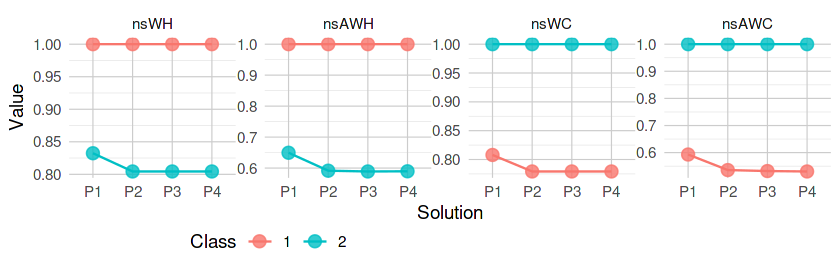

In [20]:
options(repr.plot.width=7, repr.plot.height=2.2)
pclass1 <- dfl %>% filter(prediction %in% c("P1", "P2", "P3", "P4")) %>%
ggplot(aes(x=prediction, y=value, color=class)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=class)) +
facet_wrap(~metric, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.2, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Class") +
# scale_color_brewer(palette = "Set1") +
scale_y_continuous(breaks=scales::pretty_breaks())
# ylim(0.7, 0.96)
pclass1

# P5, P6

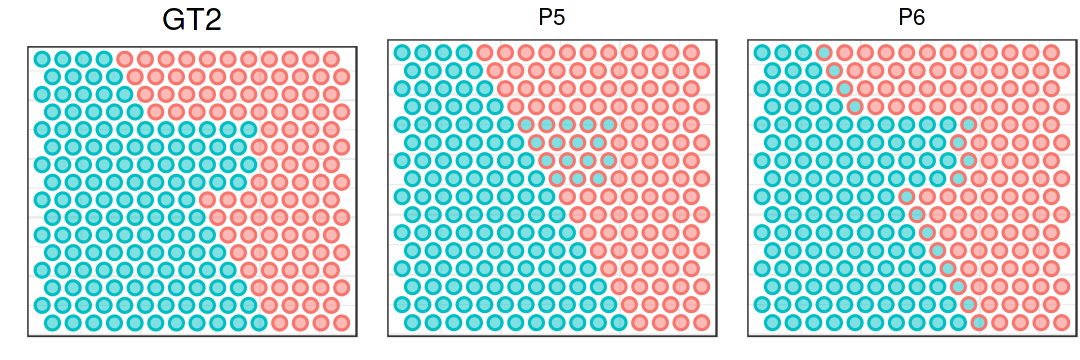

In [21]:
s <- 3
st <- 1

data$c2 <- data$p2
data$p5 <- data$label


data$p6 <- data$p2
data[data$row == 4 & (data$col %in% c(20)), "p6"] <- factor(1, levels=c(1,2))
data[data$row == 5 & (data$col %in% c(19)), "p6"] <- factor(1, levels=c(1,2))
data[data$row == 6 & (data$col %in% c(20)), "p6"] <- factor(1, levels=c(1,2))
data[data$row == 7 & (data$col %in% c(19)), "p6"] <- factor(1, levels=c(1,2))

for (i in unique(data$row)) {
  if(i !=4 & i!=5 & i!=6 & i!=7){
    data[data$row==i & data$col==i+6, "p6"] <- factor(1, levels=c(1,2))
  }
} 

pc <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=c2)) + 
  labs(x="",y="", title="GT2") 


p5 <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p5)) + 
  labs(x="",y="", title="P5") 


p6 <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p6)) + 
  labs(x="",y="", title="P6") 

options(repr.plot.width=9, repr.plot.height=3)
# grDevices::cairo_pdf("Fig1.pdf", width=10, height=3)
pc <- pc + theme(legend.position = "none",plot.title = element_text(size=18, hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
p5 <- p5 + theme(legend.position = "none",plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
p6 <- p6 + theme(legend.position = "none",plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank())
ps3 <- plot_grid(pc, p5, p6, ncol = 3)
plot(ps3)
# dev.off()


In [22]:
k <- 6
pred <- c("p5","p6")
pred_name <- c("P5","P6")
label <- data$c2
location <- data[, c('x','y')]
internal <-lapply(setNames(c("c2","p5","p6"), c("C","P5","P6")), function(x){getSpatialInternalMetrics(labels=data[[x]], location=location, k=k, level="dataset", metrics=c("PAS", "ELSA", "CHAOS","MPC", "PC", "PE"))})
internal <- bind_rows(internal,.id = "prediction")
externalSpatial <- lapply(setNames(pred, pred_name), function(x){getSpatialExternalMetrics(true=label, pred=data[[x]], location=location, level="dataset", fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, 
                                                                                                 metrics=c("nsRI","nsARI","nsWH","nsAWH", "nsWC","nsAWC","nsAccuracy","SpatialARI", "SpatialRI"),
                                                                                                useMedianDist=useMedianDist)})
externalSpatial <- bind_rows(externalSpatial, .id = "prediction")                                                                                                
externalNormal <- lapply(setNames(pred, pred_name), function(x){getPartitionMetrics(label, data[[x]], level="dataset", metrics=c("RI","WC","WH","ARI","AWC","AWH","Accuracy"))})
externalNormal <- bind_rows(externalNormal, .id = "prediction")

the specified variable is considered as categorical...
the specified variable is considered as categorical...
the specified variable is considered as categorical...


Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00042

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00173



In [23]:
internal <- pivot_longer(internal, cols=-c("prediction"), names_to = "metric", values_to = "value")
dfc <- internal %>% filter(prediction == "C")
internal <- internal %>% filter(prediction != "C")
internal <- merge(internal, dfc, by.x = c("metric"), by.y = c("metric")) %>% select(-prediction.y) %>% rename(C = value.y) %>% rename(prediction = prediction.x) %>% rename(value = value.x) 
head(internal)

,metric,prediction,value,C
,<chr>,<chr>,<dbl>,<dbl>
1,CHAOS,P5,0.23058662,0.23058662
2,CHAOS,P6,0.23058662,0.23058662
3,ELSA,P5,0.05940498,0.07990288
4,ELSA,P6,0.08638076,0.07990288
5,ELSA.Ea,P5,0.07012866,0.09483870
6,ELSA.Ea,P6,0.10071637,0.09483870


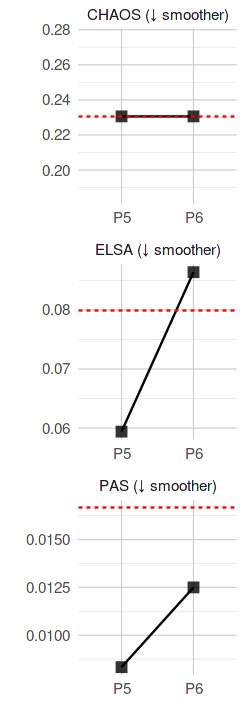

In [24]:
options(repr.plot.width=2, repr.plot.height=6)
pi2 <- internal %>% 
filter(metric %in% c("PAS", "ELSA", "CHAOS")) %>%
ggplot(aes(x=prediction, y=value)) +
geom_point(size=3, alpha=0.8, shape=15) +
geom_line(aes(group=metric)) +
facet_wrap(~metric, scales = "free", ncol=1,
            labeller = as_labeller(c("PAS" = "PAS (↓ smoother)",
                                     "ELSA" = "ELSA (↓ smoother)",
                                     "CHAOS" = "CHAOS (↓ smoother)"))) +
geom_hline(aes(yintercept = C), linetype = "dashed", color = "red") +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm"), # Adjust the space between panels)
    plot.margin = margin(0, 2, 0, 1)) +  
theme(legend.position = "bottom", legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="", x="") 
pi2

In [25]:
external <- merge(externalSpatial, externalNormal, by="prediction")
external <- pivot_longer(external, cols=-c("prediction"), names_to = "metric", values_to = "value")
external$metric_class <- sub("ns", "", external$metric)
external$metric_class <- sub("Spatial", "", external$metric_class)
external$metric_type <- ifelse(grepl("ns",external$metric) , "Neighborhood Smoothed", "NonSpatial")
external$metric_type <- ifelse(grepl("Spatial",external$metric) , "Distance Weighted", external$metric_type)
external <- data.frame(external)
external[external$metric=="nsAccuracy", "metric_class"] <- "Set Matching\nAccuracy"
external[external$metric=="Accuracy", "metric_class"] <- "Set Matching\nAccuracy"
external$metric_class <- factor(external$metric_class, levels=c('RI','ARI','WH','AWH','WC','AWC','Set Matching\nAccuracy'))

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


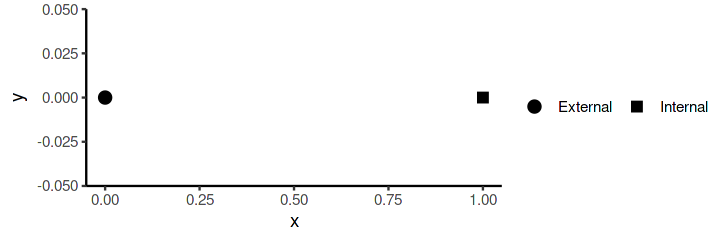

In [26]:
options(repr.plot.width=6, repr.plot.height=2)
plot_with_legend <- ggplot(data.frame(type=c("External","Internal"), x=c(0,1)), aes(x = x, y = 0, shape = type)) +
  geom_point(size=3) +
  scale_shape_manual(values = c(19, 15)) + labs(shape="") +
  theme_classic() +
  guides(shape = guide_legend(nrow = 1)) +
  theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt")) 
  
legend <- get_legend(plot_with_legend)
plot_with_legend

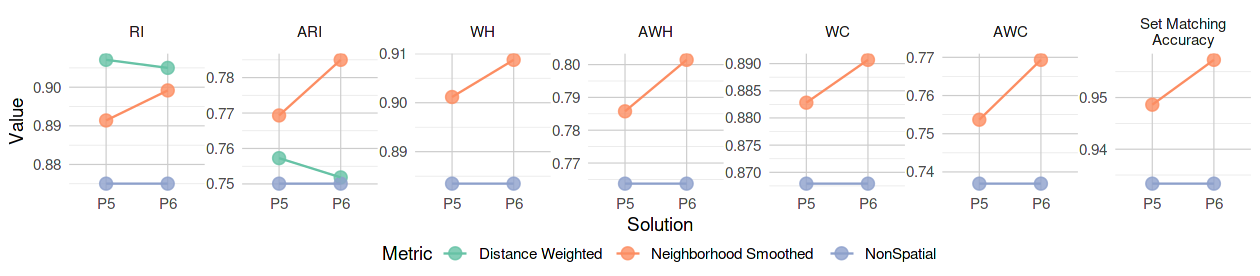

In [27]:
options(repr.plot.width=10.5, repr.plot.height=2.3)
pxx2 <- external %>% 
ggplot(aes(x=prediction, y=value, color=metric_type)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=metric)) +
facet_wrap(~metric_class, scales = "free", nrow=1) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.5, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Metric")  +
scale_color_brewer(palette = "Set2")
# ylim(0.7, 0.96)
pxx2

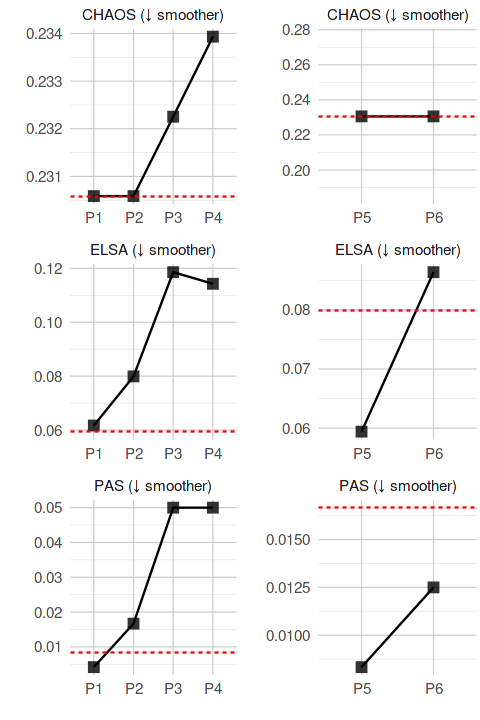

In [28]:
options(repr.plot.width=4, repr.plot.height=6)
p56 <- plot_grid(pi1 + theme(legend.position = "None"), 
          pi2 + theme(legend.position = "None"),
labels = c("",""), 
label_size = 18,
ncol = 2, rel_widths = c(1,1))

p56

In [29]:
externalSpatialClass <- do.call(rbind, lapply(setNames(pred, pred_name), function(x){as.data.frame(getSpatialExternalMetrics(true=label, pred=data[[x]], location=location, level="class", fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, metrics=c("nsWH","nsAWH", 
                                                     "nsWC","nsAWC")))}))
externalSpatialClass$prediction <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[1]})
externalSpatialClass$class <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[2]})
externalSpatialClass
dfl <- externalSpatialClass %>% pivot_longer(cols = c("nsWH","nsAWH", "nsWC","nsAWC"), names_to = "metric", values_to = "value")
dfl$metric <- factor(dfl$metric, levels=c("nsWH","nsAWH", "nsWC","nsAWC"))

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000906

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000445



,nsWH,nsAWH,nsWC,nsAWC,class,cluster,prediction
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
P5.1,NA,NA,1.0000000,1.0000000,1,NA,P5
P5.2,NA,NA,0.8144880,0.6105549,2,NA,P5
P5.3,0.8025610,0.5702889,NA,NA,3,1,P5
P5.4,1.0000000,1.0000000,NA,NA,4,2,P5
P6.1,NA,NA,1.0000000,1.0000000,1,NA,P6
P6.2,NA,NA,0.8275962,0.6390012,2,NA,P6
P6.3,0.8185141,0.6037469,NA,NA,3,1,P6
P6.4,1.0000000,1.0000000,NA,NA,4,2,P6


In [30]:
df1 <- dfl %>% filter(metric %in% c("nsWH","nsAWH")) %>% select(-class) %>%  drop_na() %>% rename(class = cluster)
df2 <- dfl %>% filter(metric %in% c("nsWC","nsAWC")) %>% select(-cluster) %>%  drop_na() 
df1 <- as.data.frame(df1)
df2 <- as.data.frame(df2)
dfl <- rbind(df1,df2)
dfl$class <- factor(dfl$class, levels=c(1,2))

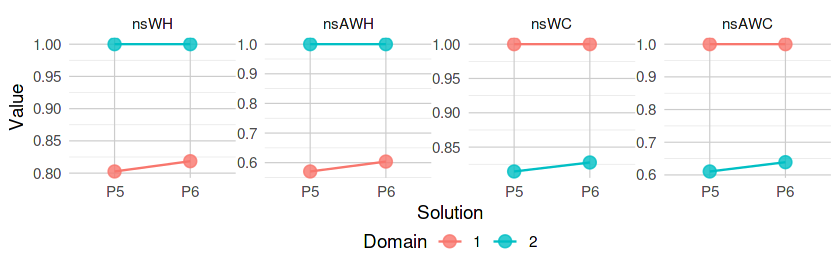

In [31]:
options(repr.plot.width=7, repr.plot.height=2.2)
pclass3 <- dfl %>% 
ggplot(aes(x=prediction, y=value, color=class)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=class)) +
facet_wrap(~metric, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", 
    # legend.justification = c(0.2, 0), 
    legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Domain") +
# scale_color_brewer(palette = "Set1") +
scale_y_continuous(breaks=scales::pretty_breaks())
# ylim(0.7, 0.96)
pclass3

In [32]:
grDevices::cairo_pdf("spatial_toy_s_class.pdf", width=6, height=3.5)
plot_grid(pclass1 + theme(legend.position = "None"), 
          pclass3,
labels = c("a", "b"), 
label_size = 18,
ncol = 1, rel_heights = c(3,3))
dev.off()

pdf 
  2

In [33]:
grDevices::cairo_pdf("spatial_toy_gt1.pdf", width=3, height=3)
print(p0)
dev.off()
grDevices::cairo_pdf("spatial_toy_p1.pdf", width=3, height=3)
print(p1)
dev.off()
grDevices::cairo_pdf("spatial_toy_p2.pdf", width=3, height=3)
print(p2)
dev.off()
grDevices::cairo_pdf("spatial_toy_p3.pdf", width=3, height=3)
print(p3)
dev.off()
grDevices::cairo_pdf("spatial_toy_p4.pdf", width=3, height=3)
print(p4)
dev.off()
grDevices::cairo_pdf("spatial_toy_p5.pdf", width=3, height=3)
print(p5)
dev.off()
grDevices::cairo_pdf("spatial_toy_p6.pdf", width=3, height=3)
print(p6)
dev.off()
grDevices::cairo_pdf("spatial_toy_gt2.pdf", width=3, height=3)
print(pc)
dev.off()



pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

In [34]:
library(magick)
library(grid)

# Read the PDF as image (raster)
pdf_img <- image_read_pdf("spatial_toy_a.pdf", density = 600)  # high density for good quality

# Convert to rasterGrob
pdf_grob <- rasterGrob(as.raster(pdf_img), interpolate = TRUE)

# Wrap as ggdraw to make it plot-like
pdf_plot <- ggdraw() + draw_grob(pdf_grob)

Linking to ImageMagick 6.9.11.60
Enabled features: fontconfig, freetype, fftw, heic, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, raw, rsvg

Using 20 threads



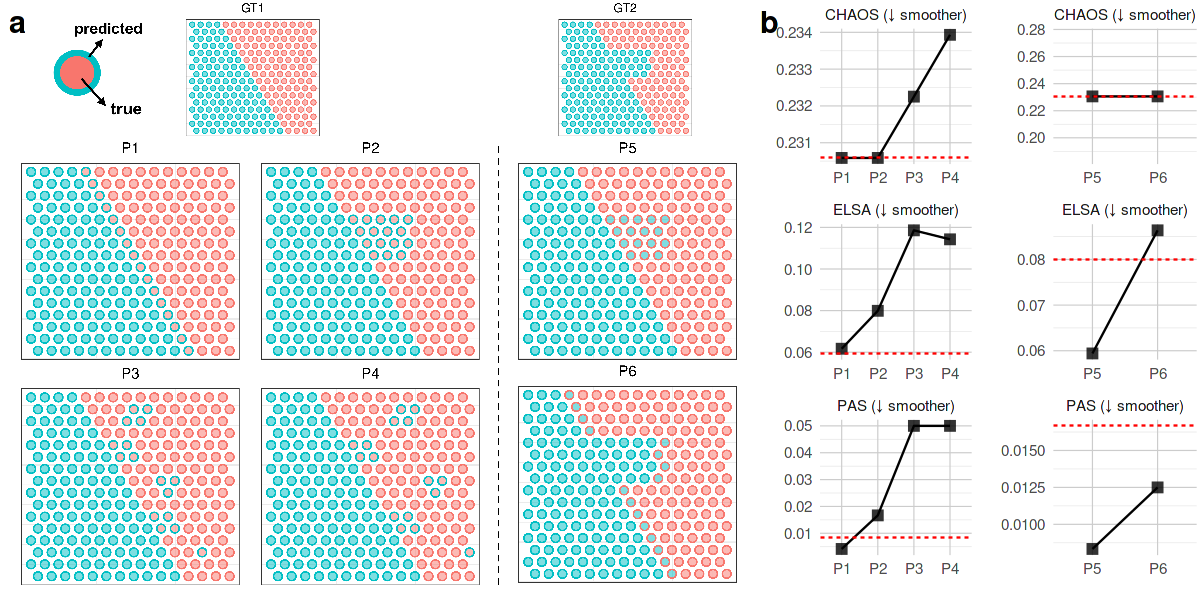

In [35]:
options(repr.plot.width=10, repr.plot.height=5)
pab <- plot_grid(pdf_plot, p56, labels=c("a", "b"), label_size=18, ncol=2, rel_widths=c(2,1.2), align="v", axis="tb")
pab

In [36]:
# grDevices::cairo_pdf("spatial_toy_s.pdf", width=10, height=11.5)
# plot_grid(ps1 + theme(legend.position = "None"), 
#           ps3 + theme(plot.margin = margin(0, 160, 0, 20)), 
#           p56,
#           pxx1, 
#           pxx2,
# labels = c("a", "", "b", "c", "d"), 
# label_size = 18,
# ncol = 1, rel_heights = c(2.4,2.4,1.6,2,2))
# dev.off()


In [36]:
grDevices::cairo_pdf("spatial_toy_s.pdf", width=10, height=9.4)
plot_grid(pab, 
          pxx1, 
          pxx2,
labels = c("", "c", "d"), 
label_size = 18,
ncol = 1, rel_heights = c(5,2.2,2.2))
dev.off()


pdf 
  2